In [ ]:
# Implementation of basic model

# 1-Importing Key Modules

In [1]:
# support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function

# I am an engineer. I care only about error not warning. So, let's be maverick and ignore warnings.
import warnings
warnings.filterwarnings('ignore')

In [2]:
import re    # for regular expressions 
import nltk  # for text manipulation 
import string 
import numpy as np 
import pandas as pd 

#For Visuals
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [3]:
#models and evaluation

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from nltk.classify.scikitlearn import SklearnClassifier # notice its from ntlk not sklearn
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
# Evaluation packages
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [4]:
# testing GPU on colab
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

# 2)-Loading data

In [5]:
data=pd.read_csv('train_data_10000.csv')
data=data.rename(columns={'Unnamed: 0':'random_columns'}) # a trick to tackle random index values
data=data.drop(["random_columns"], axis=1)
data.shape

(10000, 2)

In [6]:
data.head(2)

,news,category
0,Top 5 Reasons Why 'Divergent' Star Kate Winsle...,e
1,Vessyl Bottle Tracks Your Drink And Its Health...,t


In [7]:
data.isnull().sum()

news        0
category    0
dtype: int64

# 3-Data Cleaning

In [8]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;#]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z +_]')
STOPWORDS = stopwords.words('english')
#STOPWORDS.extend(['http','https','www']) # extend stopwords. If We  had few www or https.
STOPWORDS = set(STOPWORDS)

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join([word for word in text.split() if word not in STOPWORDS]) # delete stopwords from text
    text = text.strip()
    return text

In [10]:
data['clean']=[text_prepare(x) for x in data['news']]

In [11]:
# Dictionary of all words from train corpus with their counts.
words_counts = {}

from collections import Counter
words_counts = Counter([word for line in data['clean'] for word in line.split(' ')])

# Sorting 
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:10]

# Top 10
most_common_words[:10]

[('news', 998),
 ('new', 655),
 ('times', 522),
 ('blog', 442),
 ('us', 422),
 ('business', 318),
 ('daily', 316),
 ('post', 296),
 ('google', 266),
 ('apple', 221)]

### 3.1.Lemma
Normalize

In [12]:
from nltk.stem import WordNetLemmatizer
lemm = WordNetLemmatizer()

In [13]:
tokenized_text = data['clean'].apply(lambda x: x.split()) # tokenizing 
print(tokenized_text[9])

['could', 'ted', 'lawsuit', 'keep', 'ted', '2', 'happeningmoviefone']


In [14]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [15]:
tokenized_text = tokenized_text.apply(lambda x: [lemm.lemmatize(i) for i in x])
print(tokenized_text[2])

['conjoined', 'twin', 'leave', 'dallas', 'hospital', 'month', 'separated', 'tribune']


### 3.2.using stemmer

In [16]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer(language='english')

In [17]:
tokenized_text = data['clean'].apply(lambda x: x.split()) # tokenizing 
tokenized_text = tokenized_text.apply(lambda x: [stemmer.stem(i) for i in x])
print(tokenized_text[2])

['conjoin', 'twin', 'leav', 'dalla', 'hospit', 'month', 'separ', 'tribun']


In [18]:
# stitch these tokens back together.

for i in range(len(tokenized_text)):
    tokenized_text[i] = ' '.join(tokenized_text[i])    
data['clean'] = tokenized_text

In [19]:
#before clean
data['news'].apply(lambda x: len(x.split(' '))).sum()

103496

In [20]:
#after clean
data['clean'].apply(lambda x: len(x.split(' '))).sum()

81669

### save for future work

In [21]:
data.to_csv('train_data_clean.csv',index=False)

# 4-Model Building

In [22]:
#Function for category id
data['category_id'] = data['category'].factorize()[0]
category_id_df = data[['category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)

In [40]:
#vectorization
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(data.clean).toarray()
labels = data['category'].astype(str)

In [41]:
print(features.shape)
print(labels.shape)

(10000, 3438)
(10000,)


In [25]:
# model fit

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [26]:
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.7980
1,RandomForestClassifier,1,0.8045
2,RandomForestClassifier,2,0.7995
3,RandomForestClassifier,3,0.7915
4,RandomForestClassifier,4,0.7910
5,LinearSVC,0,0.8520
6,LinearSVC,1,0.8505
7,LinearSVC,2,0.8430
8,LinearSVC,3,0.8470
9,LinearSVC,4,0.8525


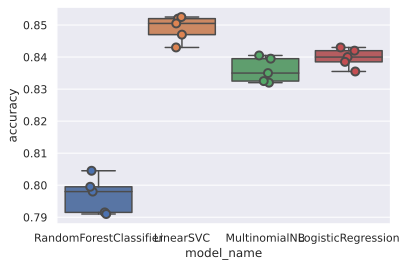

In [27]:
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [28]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.8490
LogisticRegression        0.8398
MultinomialNB             0.8359
RandomForestClassifier    0.7969
Name: accuracy, dtype: float64

# 5- Model Selection & Evaluation

In [42]:
print(features.shape)
print(labels.shape)

(10000, 3438)
(10000,)


In [43]:
model1 = LinearSVC() #using best performing model
model1.fit(features, labels) # training on whole train data

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [44]:
#loading test feature and label data saved from previous notebooks
feature_test=pd.read_csv('test_data.csv')
label_test=pd.read_csv('test_label.csv')

In [45]:
print(feature_test.shape)
print(label_test.shape)

(84484, 2)
(84484, 1)


In [46]:
feature_test.head(2)

,Unnamed: 0,title
0,153245,iPhone 6 Release Date Pushed Back Due to Issue...
1,308611,Samsung Galaxy S4 vs Galaxy S3: Budget-Friendl...


In [47]:
features_test = tfidf.transform(feature_test.title).toarray()

In [48]:
print(features_test.shape)

(84484, 3438)


In [50]:
y_pred = model1.predict(features_test)
print(y_pred.shape)

(84484,)


In [51]:
from sklearn.metrics import accuracy_score
print(accuracy_score(label_test, y_pred))

0.7642038729226835


In [52]:
y_pred[:5]

array(['e', 't', 'e', 'm', 'b'], dtype=object)

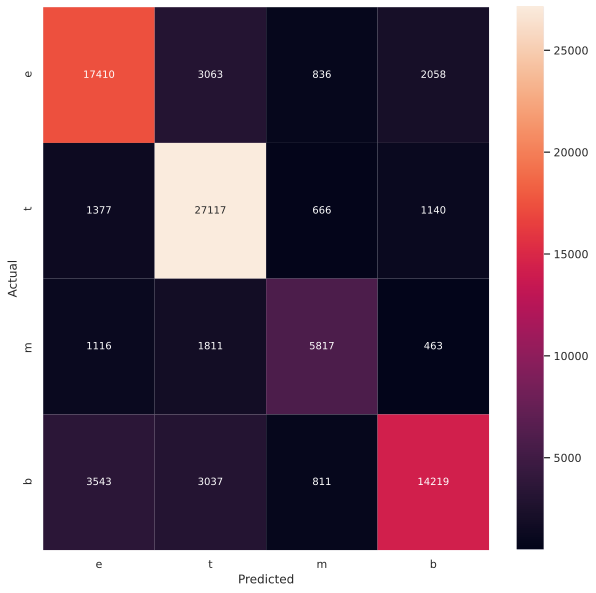

In [53]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(label_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [54]:
from sklearn import metrics
print(metrics.classification_report(label_test, y_pred))

              precision    recall  f1-score   support

           b       0.74      0.75      0.74     23367
           e       0.77      0.89      0.83     30300
           m       0.72      0.63      0.67      9207
           t       0.80      0.66      0.72     21610

    accuracy                           0.76     84484
   macro avg       0.76      0.73      0.74     84484
weighted avg       0.76      0.76      0.76     84484



In [56]:
print(labels.nunique())
print(label_test.nunique())

4
category    4
dtype: int64


# 6-api idea
key: text <br>
output1: class prediction <br>
output2: probability of each class (higher is better) <br>

In [57]:
texts=["YouTube updates to include crowd-funding options"]

In [58]:
text_features = tfidf.transform(texts)
pred_class = model1.predict(text_features)
score=model1._predict_proba_lr(text_features)

In [59]:
pd.DataFrame(model1._predict_proba_lr(text_features), columns=model1.classes_)

,b,e,m,t
0,0.317146,0.320885,0.200135,0.161834


In [60]:
prob=score.max(axis=1)
prob

array([0.3208853])

In [61]:
result=texts
result=pd.DataFrame(result,columns=["text"])
result["news-type"]=pred_class
result["probability"]=prob

In [62]:
result

,text,news-type,probability
0,YouTube updates to include crowd-funding options,e,0.320885


In [63]:
json_img = result.to_json(orient='records')  
json_img

'[{"text":"YouTube updates to include crowd-funding options","news-type":"e","probability":0.3208852961}]'